#XGBoost
-Gradient Boosting보다 빠르다.

-과적합 방지가 있다.

-CART ( Classification And Regression Trees ) 기반한 알고리즘

-자체 교차검증 함수가 있다.


#준비 작업



In [0]:
!pip install ipython-autotime
%load_ext autotime

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) 
import missingno as msno

%matplotlib inline

time: 403 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive
time: 1.04 s


In [0]:
%cd "/content/gdrive/My Drive/4th_2020/kisti_kaggle"
!ls -al ./datasets

/content/gdrive/My Drive/4th_2020/kisti_kaggle
total 92
-rw------- 1 root root  3258 Jun  2 07:07 sample_submission.csv
-rw------- 1 root root 28629 Jun  2 07:07 test.csv
-rw------- 1 root root 61194 Jun  2 07:07 train.csv
time: 1.71 s


In [0]:
WORK_DIR = '.'
df_train = pd.read_csv(WORK_DIR + '/datasets/train.csv')
df_test = pd.read_csv(WORK_DIR + '/datasets/test.csv')

time: 20.2 ms


#Feafure Engineering

In [0]:
# initial 항목으로 추출
df_train['Initial']=0
for i in df_train:
    df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') 
    
df_test['Initial']=0
for i in df_test:
    df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')

df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                          'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                       'Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess',
                          'Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other',
                         'Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_all = pd.concat([df_train, df_test])
df_all
df_all.reset_index(drop=True)

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=37
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=45

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=37
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=45

df_train['Embarked'].fillna('S', inplace=True)

# loc 이용
# 10살 간격으로 나누기
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

# Age 컬럼 삭제
# axis=1
df_train.drop(['Age'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

df_train['Initial'] = df_train['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map(
    {'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_train.Initial.unique() 

df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})


df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 

print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

Maximum size of Family:  11
Minimum size of Family:  1
time: 341 ms


In [0]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

df_train.head()

Survived  Pclass  Sex  ...  Embarked_0  Embarked_1  Embarked_2
0         0       3    1  ...           0           0           1
1         1       1    0  ...           1           0           0
2         1       3    0  ...           0           0           1
3         1       1    0  ...           0           0           1
4         0       3    1  ...           0           0           1

[5 rows x 14 columns]

time: 51.5 ms


#분류 모델 생성

In [0]:
from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgb

time: 1.72 ms


XGBooster의 파라메터

    Booster [default = gbtree] 
        - 어떤 방식으로 학습할것인가
                gbtee : tree - based models
                gblinear : linear models
    silent [default = 0] 
        - 동작 메시지 출력 여부
    eta, learning rate [default = 0.3] 
        - 학습률
    max_depth [default = 6]           
        - 최대 깊이
    Max_leaf_nodes
        - 트리의 최하단 노드 또는 잎의 최대 수 (Max_depth 가 무시됨)
    gamma [default = 0]
        - 분할을 수행하는데 필요한 최소 손실 감소를 지정 






##기본적인 방법

In [0]:
X_train = df_train.drop('Survived', axis=1)
target_label = df_train['Survived']
X_test = df_test

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

time: 8.42 ms


In [0]:
#모델 생성
xgb_model = XGBClassifier()

time: 1.33 ms


학습시 파라매터들이 기본값으로 자동으로 들어가진다

In [0]:
xgb_model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

time: 62.1 ms


In [0]:
xgb_model.predict(X_vld)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1])

time: 7.66 ms


In [0]:
# 정확도
print("정확도 :", 100 * metrics.accuracy_score(xgb_model.predict(X_vld), y_vld))

정확도 : 84.70149253731343
time: 6.36 ms


##모델 튜닝

최적의 파라매터값을 찾는것이 핵심

In [0]:
xgb_model = XGBClassifier(max_depth=2)

time: 1.25 ms


In [0]:
xgb_model.fit(X_tr,y_tr)
xgb_pred = xgb_model.predict(X_vld)
print(metrics.accuracy_score(xgb_pred, y_vld))

0.8582089552238806
time: 46 ms


In [0]:
accuracy_list = []

max_depth_list = [1,2,5,7,9,11]

for max_depth in max_depth_list:
    xgb_model = xgb.XGBClassifier(max_depth=max_depth)
    xgb_model.fit(X_tr,y_tr)
    xgb_pred = xgb_model.predict(X_vld)
    xgb_accuracy = metrics.accuracy_score(xgb_pred,y_vld ) 
    accuracy_list.append(xgb_accuracy)

xgb_df = pd.DataFrame({'Tree depth':max_depth_list, 'accuracy':accuracy_list})
xgb_df    



Tree depth  accuracy
0           1  0.854478
1           2  0.858209
2           5  0.850746
3           7  0.847015
4           9  0.835821
5          11  0.835821

time: 460 ms


In [0]:
xgb_model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

time: 124 ms


##Grid Search

In [0]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

time: 2.71 ms


In [0]:
xgb_model= xgb.XGBClassifier()

xgb_param_grid = {'max_depth': [3,5,7],
              'subsample': [0.6, 0.8, 1.0]}

xgb_grid = GridSearchCV(estimator=xgb_model,
                       param_grid=xgb_param_grid,
                       scoring="roc_auc",
                        return_train_score=True,
                       cv=4)




xgb_grid.fit(X_tr,y_tr)

GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7], 'subsample': [0.6, 0.8, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='

time: 2.43 s


In [0]:
grid_df = pd.DataFrame(xgb_grid.cv_results_)
grid_df.loc[:, ['mean_test_score', "params"]]

mean_test_score                              params
0         0.865605  {'max_depth': 3, 'subsample': 0.6}
1         0.866700  {'max_depth': 3, 'subsample': 0.8}
2         0.864625  {'max_depth': 3, 'subsample': 1.0}
3         0.865033  {'max_depth': 5, 'subsample': 0.6}
4         0.863799  {'max_depth': 5, 'subsample': 0.8}
5         0.856585  {'max_depth': 5, 'subsample': 1.0}
6         0.868595  {'max_depth': 7, 'subsample': 0.6}
7         0.860178  {'max_depth': 7, 'subsample': 0.8}
8         0.856561  {'max_depth': 7, 'subsample': 1.0}

time: 20.9 ms


In [0]:
grid_df.loc[:, ['mean_test_score', "params"]].sort_values(by='mean_test_score', ascending=False, inplace=False)

mean_test_score                              params
6         0.868595  {'max_depth': 7, 'subsample': 0.6}
1         0.866700  {'max_depth': 3, 'subsample': 0.8}
0         0.865605  {'max_depth': 3, 'subsample': 0.6}
3         0.865033  {'max_depth': 5, 'subsample': 0.6}
2         0.864625  {'max_depth': 3, 'subsample': 1.0}
4         0.863799  {'max_depth': 5, 'subsample': 0.8}
7         0.860178  {'max_depth': 7, 'subsample': 0.8}
5         0.856585  {'max_depth': 5, 'subsample': 1.0}
8         0.856561  {'max_depth': 7, 'subsample': 1.0}

time: 16.5 ms


In [0]:
print(metrics.accuracy_score(xgb_grid.predict(X_vld), y_vld))

0.8544776119402985
time: 7.39 ms


##Random Search

In [0]:

xgb_param_rand = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}
xgb_model = XGBClassifier()

xgb_random = RandomizedSearchCV(param_distributions=xgb_param_rand, 
                                 estimator = xgb_model,
                                 scoring = "roc_auc", 
                                verbose = 1,
                                 n_iter = 50,
                                 cv = 4)

xgb_random.fit(X_tr, y_tr)



Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.5s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...ght=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated

time: 3.48 s


In [0]:
print()
print("Best parameters found: ", xgb_random.best_params_)
print("Best accuracy found: ", xgb_random.best_score_)
print()


Best parameters found:  {'n_estimators': 8, 'max_depth': 7, 'learning_rate': 0.6, 'colsample_bytree': 0.6}
Best accuracy found:  0.8669489449641521

time: 2.54 ms


In [0]:
xgb_random.predict(X_vld)
print(metrics.accuracy_score(xgb_random.predict(X_vld), y_vld))

0.8432835820895522
time: 7.1 ms


##자체 교차검증

In [0]:
xgb_model=xgb.XGBClassifier()

dmat = xgb.DMatrix(data=X_tr, label=y_tr)
xgb_param_cv = {"objective":"binary:logistic", 
             "n_estimators": 700, 
             "max_depth":7,
                "learning_rate": 0.1
}
xgb_cv= xgb.cv(params=xgb_param_cv, dtrain=dmat,num_boost_round=5000,
               metrics=['auc'],
               early_stopping_rounds=50, stratified=True)



time: 239 ms


In [0]:
#최적의 트리
xgb_model.set_params(n_estimators=xgb_cv.shape[0])

xgb_model.fit(X_tr,y_tr)
ped=xgb_model.predict(X_test)

time: 30.3 ms


In [0]:
ped

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

time: 3.94 ms


#회귀 모델 생성

In [0]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_tr,y_tr)

[11:43:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

time: 50.3 ms


In [0]:
xgb_model.predict(X_vld)


array([ 1.18185192e-01,  1.94701523e-01,  3.73935491e-01, -4.50849533e-04,
        9.90829766e-01,  3.81345451e-02,  5.31012416e-02,  3.80207002e-02,
        2.79456973e-02,  4.53065842e-01,  1.73722744e-01,  8.71243119e-01,
        5.10247469e-01,  4.14544255e-01,  7.95919597e-02,  3.71982872e-01,
        3.99410725e-02,  9.59766507e-01,  9.65144038e-01,  2.39138424e-01,
        9.96885896e-02,  3.63552570e-02,  1.16047740e-01,  8.99581313e-02,
        9.96885896e-02,  4.20027792e-01,  7.21553862e-02,  4.80361283e-02,
        7.95919597e-02,  2.81003743e-01,  7.51865208e-02,  2.70362496e-02,
       -6.43869638e-02,  7.76514590e-01,  8.88152957e-01,  3.38592798e-01,
       -5.26254773e-02,  4.15128171e-01,  1.00554556e-01,  8.39687586e-02,
        7.95919597e-02,  7.30168223e-02,  1.83026880e-01,  8.21998954e-01,
        2.79456973e-02,  5.70960939e-01,  8.34404171e-01,  9.38534260e-01,
        3.86912823e-02,  8.39687586e-02,  7.72405148e-01,  5.31012416e-02,
        8.21355224e-01,  

time: 10.8 ms


In [0]:
temp = np.round(xgb_model.predict(X_test))
temp= np.abs(temp)

time: 5.08 ms


In [0]:
temp

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

time: 9.06 ms


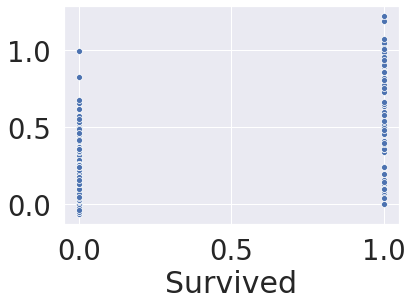

time: 314 ms


In [0]:
sns.scatterplot(y_vld, xgb_model.predict(X_vld))

#시각화

In [0]:
xgb_model = XGBClassifier(max_depth=2)
xgb_model.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

time: 40.2 ms


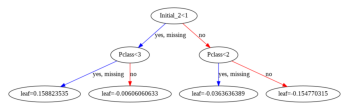

time: 307 ms


In [0]:
xgb.plot_tree(xgb_model)

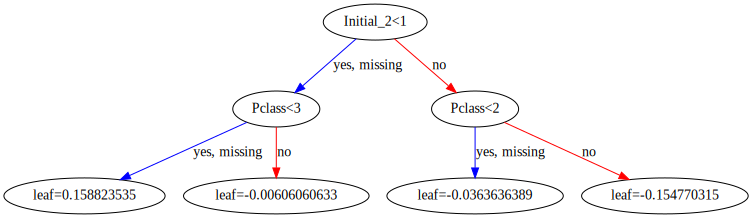

time: 25.1 ms


In [0]:
xgb.to_graphviz(xgb_model)

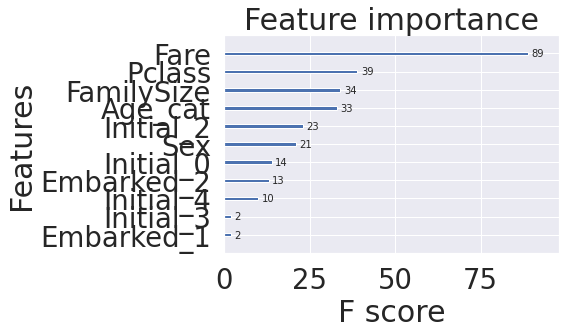

time: 323 ms


In [0]:
xgb.plot_importance(xgb_model)

#참고문헌

    https://statkclee.github.io/model/model-python-xgboost-hyper.html
    https://xgboost.readthedocs.io/en/latest/tutorials/model.html
    https://lsjsj92.tistory.com/547
